# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data.

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook.

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Size of the images: (128, 128)


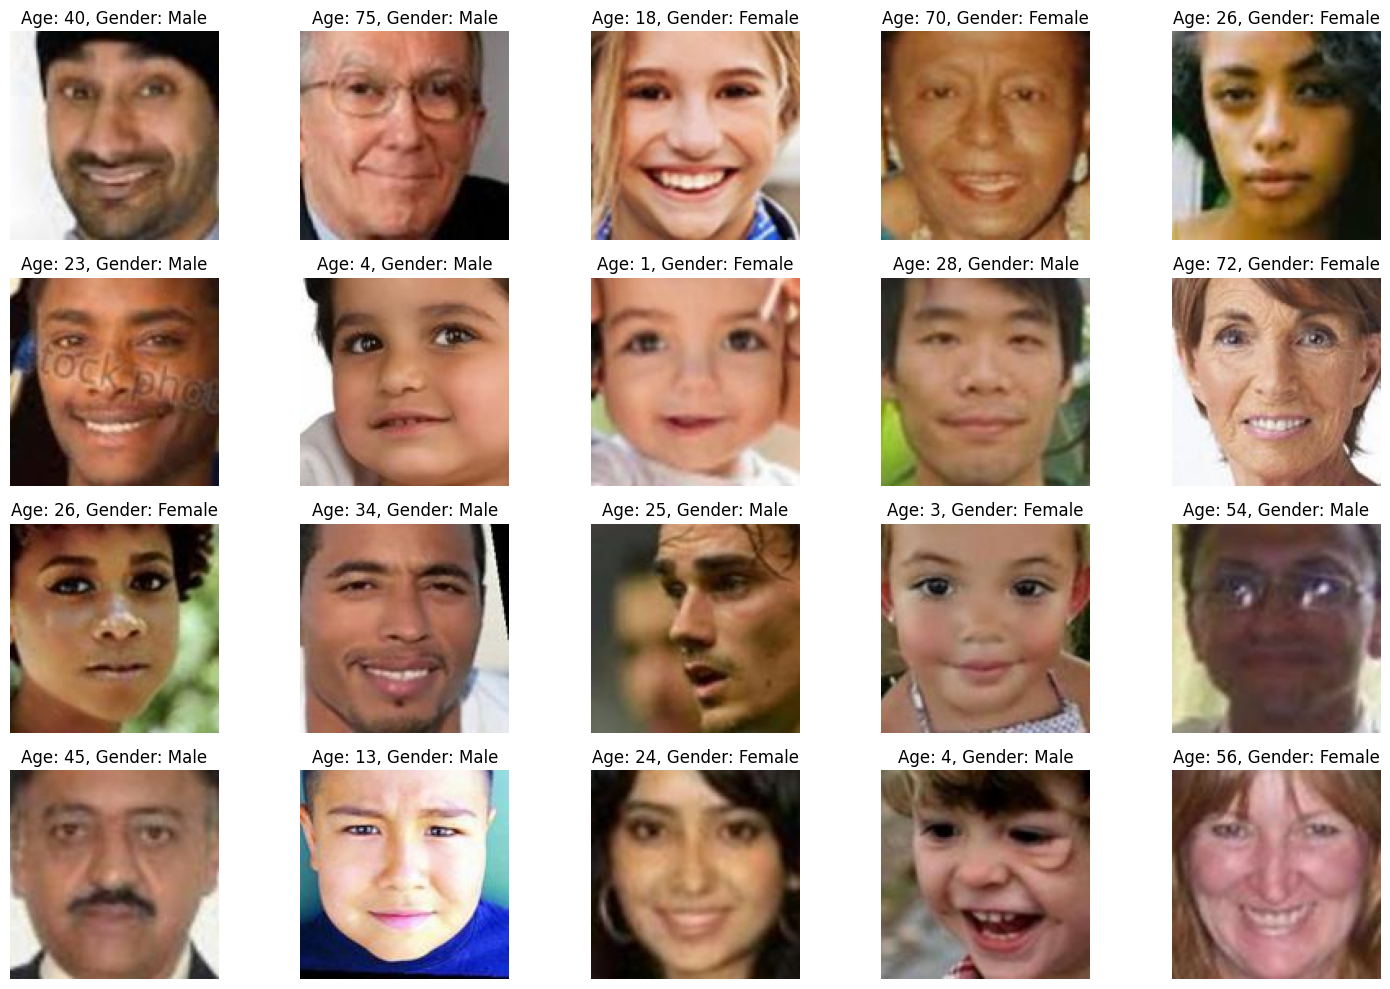

In [ ]:
#
# Add your code here
#
import re
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
img_list = []
age_list = []
gender_list = []
dataset_dir = '/content/drive/MyDrive/Colab Notebooks/train_val/'

file_names = os.listdir(dataset_dir)

# Select the first twenty images
selected_files = file_names[:20]

for file_name in selected_files:
    age_gender_match = re.match(r'(\d+)_(\d)_.*\.jpg', file_name)
    if age_gender_match:

        age_list.append(int(age_gender_match.group(1)))
        gender_list.append(int(age_gender_match.group(2)))

        img = Image.open(dataset_dir + file_name)
        img_list.append(img)

# Show the size of images
if img_list:
    print(f"Size of the images: {img_list[0].size}")


plt.figure(figsize=(15, 10))

# Show title of each image
for i in range(len(img_list)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(np.array(img_list[i]))
    plt.title(f"Age: {age_list[i]}, Gender: {'Male' if gender_list[i] == 0 else 'Female'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
#
# Add your code here
#
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from sklearn.model_selection import train_test_split

dataset_dir = '/content/drive/MyDrive/Colab Notebooks/train_val/'
image_paths = []
age_labels = []
gender_labels = []

#Read files in the dataset directory ending with .jpg
for filename in tqdm(os.listdir(dataset_dir)):
    if filename.endswith('.jpg'):
        image_path = os.path.join(dataset_dir, filename)
        temp = filename.split('_')
        age = int(temp[0])
        gender = int(temp[1])

        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)

# Create dataframe including image_paths, age, and gender columns.
df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})


  0%|          | 0/5000 [00:00<?, ?it/s]

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way.
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage.

In [ ]:
#
# Add your code here
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

df['gender'] = pd.to_numeric(df['gender'])
df['age'] = pd.to_numeric(df['age'])


# Split the train set and validation set
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Data augmentation of training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
)

# Data augmentaion of validation set
val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    class_mode='multi_output',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    class_mode='multi_output',
    batch_size=32
)

Found 4000 validated image filenames.
Found 1000 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting.

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_64 (Conv2D)          (None, 126, 126, 32)         864       ['input_18[0][0]']            
                                                                                                  
 batch_normalization_94 (Ba  (None, 126, 126, 32)         128       ['conv2d_64[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 126, 126, 32)         0         ['batch_normalization_9

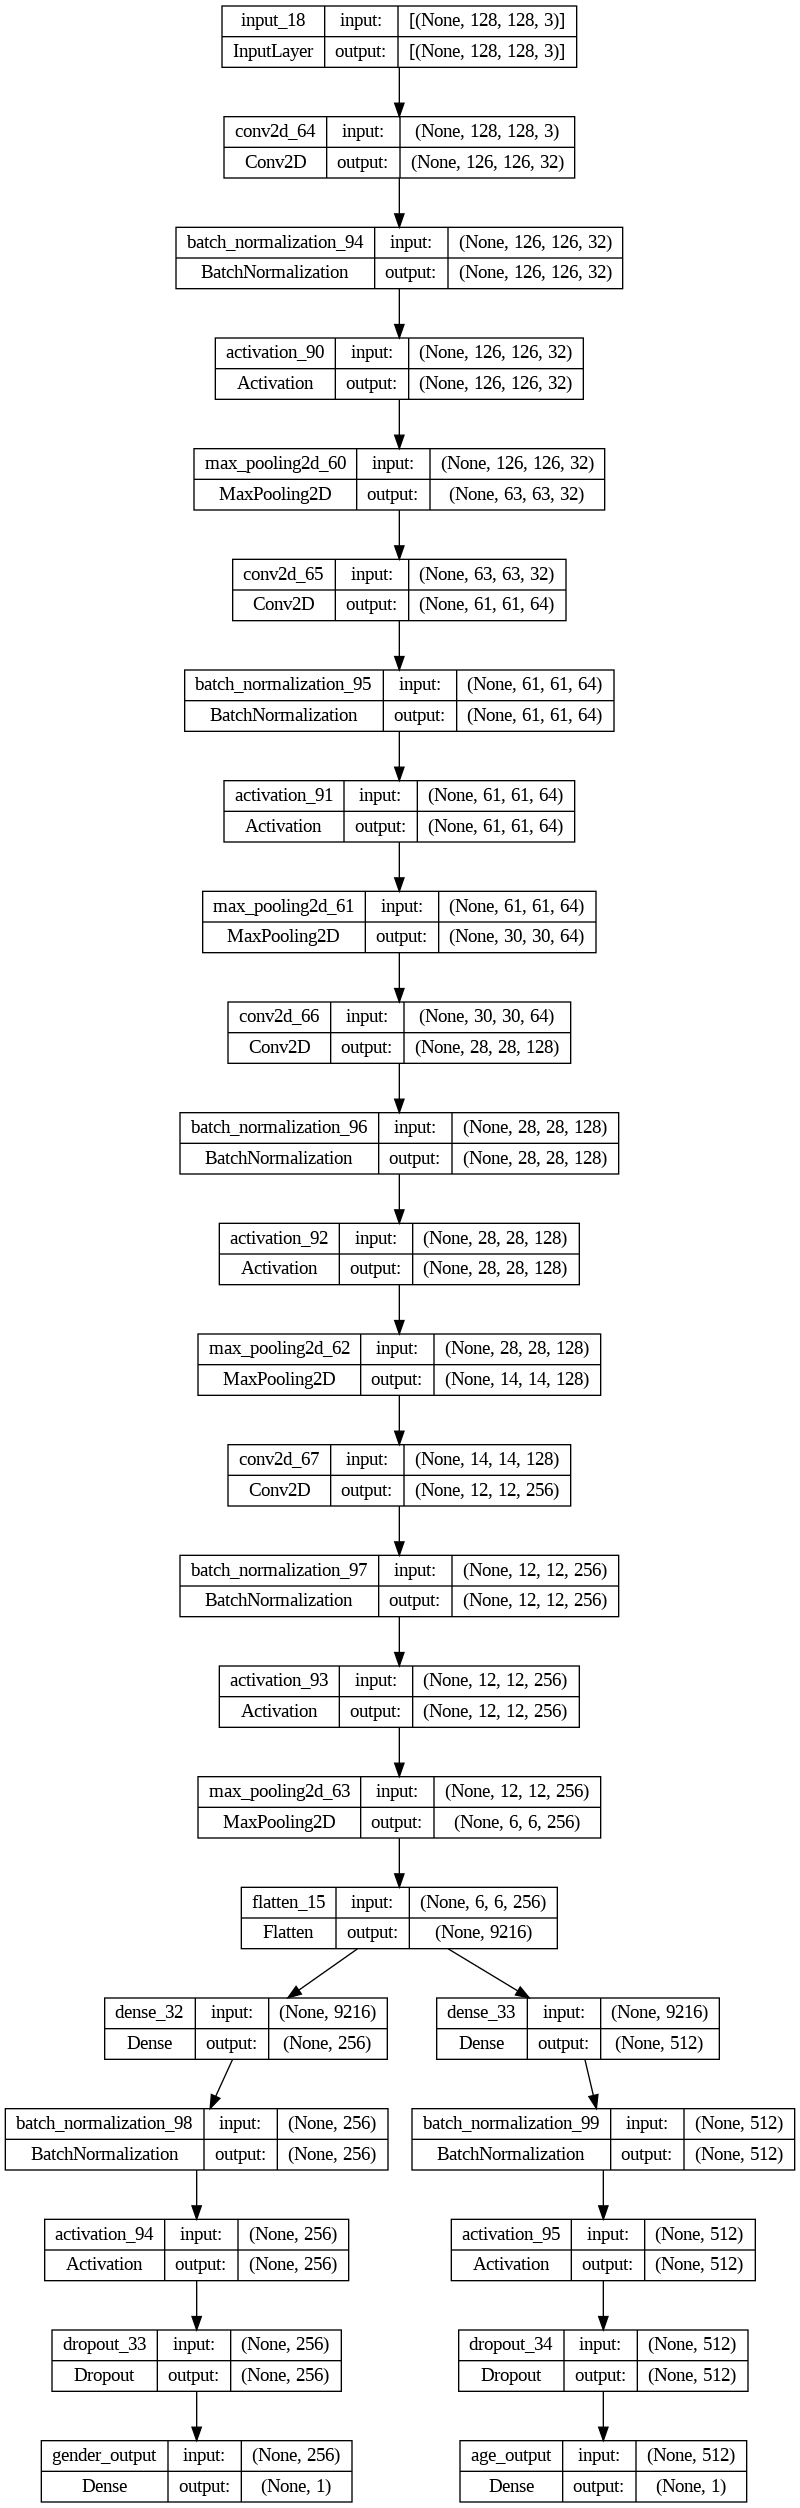

In [54]:
import keras.utils
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Activation, GlobalAveragePooling2D
from keras.models import Model
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler


# Define L2 regularization parameter
l2_reg = 0.005

input_shape = (128, 128, 3)

inputs = Input(shape=input_shape)


# Convolutional layers with Batch Normalization
conv_1 = Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(l2_reg))(inputs)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Activation('relu')(conv_1)
maxp_1 = MaxPooling2D((2, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), use_bias=False, kernel_regularizer=l2(l2_reg))(maxp_1)
conv_2 = BatchNormalization()(conv_2)
conv_2 = Activation('relu')(conv_2)
maxp_2 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(128, (3, 3), use_bias=False, kernel_regularizer=l2(l2_reg))(maxp_2)
conv_3 = BatchNormalization()(conv_3)
conv_3 = Activation('relu')(conv_3)
maxp_3 = MaxPooling2D((2, 2))(conv_3)

conv_4 = Conv2D(256, (3, 3), use_bias=False, kernel_regularizer=l2(l2_reg))(maxp_3)
conv_4 = BatchNormalization()(conv_4)
conv_4 = Activation('relu')(conv_4)
maxp_4 = MaxPooling2D((2, 2))(conv_4)

flatten = Flatten()(maxp_4)


# Dense layers for gender output
dense_1 = Dense(256, use_bias=False, kernel_regularizer=l2(l2_reg))(flatten)
dense_1 = BatchNormalization()(dense_1)
dense_1 = Activation('relu')(dense_1)
dropout_1 = Dropout(0.4)(dense_1)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)

# Dense layers for age output
dense_2 = Dense(512, use_bias=False, kernel_regularizer=l2(0.006))(flatten)
dense_2 = BatchNormalization()(dense_2)
dense_2 = Activation('relu')(dense_2)
dropout_2 = Dropout(0.4)(dense_2)
age_output = Dense(1, activation='relu' ,name='age_output')(dropout_2)

modelA = Model(inputs=inputs, outputs=[gender_output, age_output])
modelA.summary()

from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by

`modelA = load_model(model_folder+"age_gender_A.h5")`.


In [55]:
#
# Add your code here
#

# Learning rate schedule setting
learning_rate_scheduler = keras.callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

# Compile
modelA.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
              metrics={'gender_output': 'accuracy','age_output': 'mae'})
history = modelA.fit(
    train_generator,
    steps_per_epoch=len(train_df) // 32,
    epochs=45,
    validation_data=val_generator,
    validation_steps=len(val_df) // 32,
    callbacks=[learning_rate_scheduler])

# Save model
your_model_folder = '/content/drive/MyDrive/Colab Notebooks/'
modelA.save(your_model_folder+"age_gender_A.h5")

Epoch 1/45
125/125 [==============================] - 90s 271ms/step - loss: 715.0263 - gender_output_loss: 0.6586 - age_output_loss: 703.9501 - gender_output_accuracy: 0.6850 - age_output_mae: 20.8372 - val_loss: 577.1556 - val_gender_output_loss: 0.6115 - val_age_output_loss: 565.8632 - val_gender_output_accuracy: 0.6099 - val_age_output_mae: 18.7612 - lr: 0.0010
Epoch 2/45
125/125 [==============================] - 33s 260ms/step - loss: 237.8828 - gender_output_loss: 0.5534 - age_output_loss: 226.0148 - gender_output_accuracy: 0.7337 - age_output_mae: 11.3154 - val_loss: 280.7161 - val_gender_output_loss: 0.5460 - val_age_output_loss: 268.2657 - val_gender_output_accuracy: 0.7722 - val_age_output_mae: 12.5940 - lr: 9.0484e-04
Epoch 3/45
125/125 [==============================] - 35s 277ms/step - loss: 195.9638 - gender_output_loss: 0.5223 - age_output_loss: 183.1906 - gender_output_accuracy: 0.7437 - age_output_mae: 10.2596 - val_loss: 278.9776 - val_gender_output_loss: 0.5966 - va

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


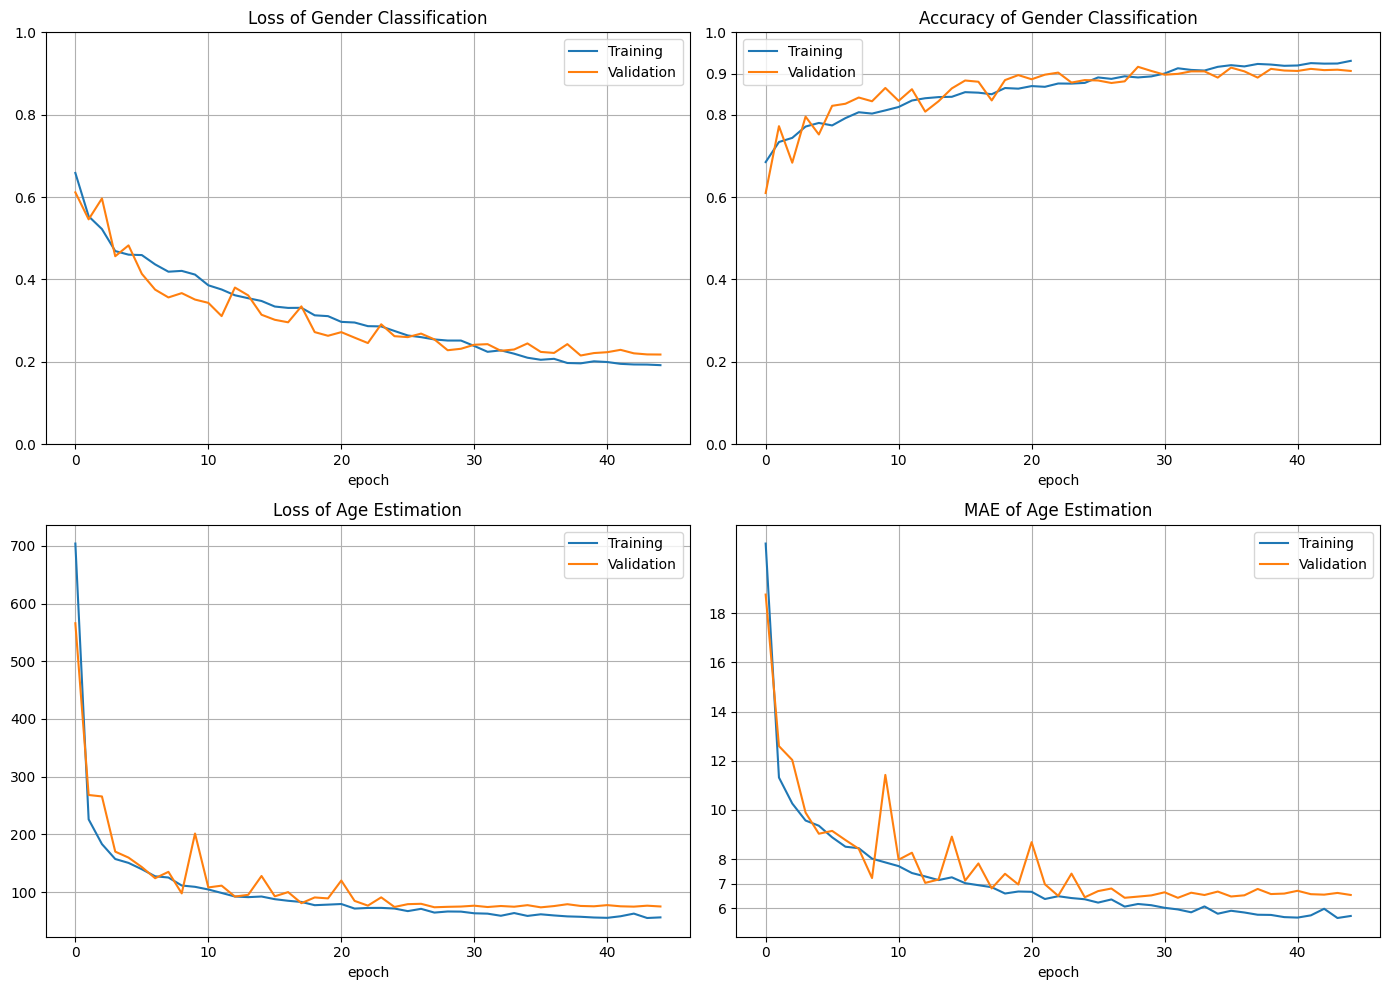

In [56]:
#
# Add your code here
#

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,10))

# Figure 1: Loss of Gender
ax1 = fig.add_subplot(2,2,1)
ax1.plot(history.history['gender_output_loss'], label='Training')
ax1.plot(history.history['val_gender_output_loss'], label='Validation')
ax1.legend()
ax1.grid(True)
ax1.set_title('Loss of Gender Classification')
ax1.set_ylim([0,1.0])
ax1.set_xlabel('epoch')

# Figure 2: Accuracy of Gender
ax2 = fig.add_subplot(2,2,2)
ax2.plot(history.history['gender_output_accuracy'], label='Training')
ax2.plot(history.history['val_gender_output_accuracy'], label='Validation')
ax2.legend()
ax2.grid(True)
ax2.set_title('Accuracy of Gender Classification')
ax2.set_ylim([0,1.0])
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
ax2.set_xlabel('epoch')

# Figure 3: Loss of Age
ax3 = fig.add_subplot(2,2,3)
ax3.plot(history.history['age_output_loss'], label='Training')
ax3.plot(history.history['val_age_output_loss'], label='Validation')
ax3.legend()
ax3.grid(True)
ax3.set_title('Loss of Age Estimation')
ax3.set_xlabel('epoch')

# Figure 4: MAE of Age
ax4 = fig.add_subplot(2,2,4)
ax4.plot(history.history['age_output_mae'], label='Training')
ax4.plot(history.history['val_age_output_mae'], label='Validation')
ax4.legend()
ax4.grid(True)
ax4.set_title('MAE of Age Estimation')
ax4.set_yticks([6, 7, 8, 10, 12, 14, 16, 18])
ax4.set_xlabel('epoch')

plt.tight_layout()
plt.show()


## STEP2B: Build a CNN network based on a pre-trained model
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**.

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Found 4000 validated image filenames.
Found 1000 validated image filenames.
83683744/83683744 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, 4, 4, 2048)           2086148   ['input_7[0][0]']             
                                                          0                                       
                                                                                                  
 global_average_pooling2d (  (None, 2048)                 0         ['xception[0][0]']            
 GlobalAveragePooling2D)                          

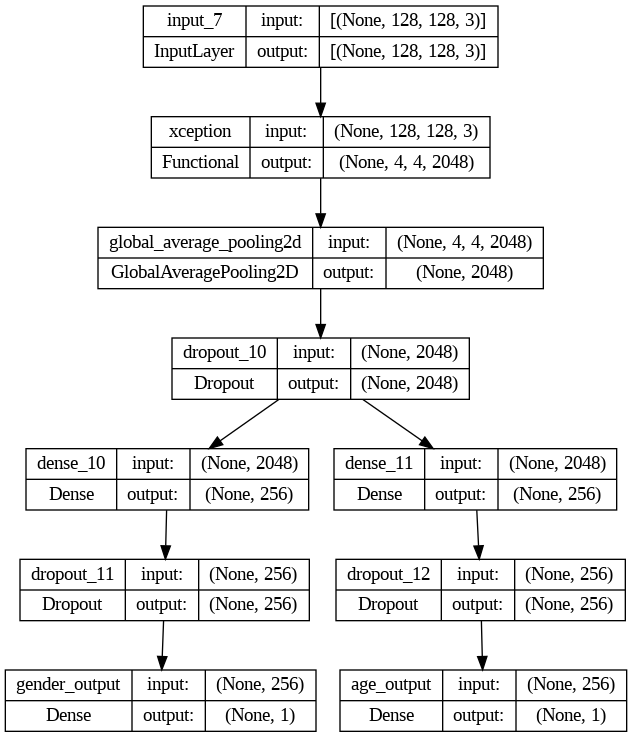

In [ ]:
#
# Add your code here
#
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras
from keras.models import Model

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 30,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    horizontal_flip = True,
    fill_mode = 'nearest')
# Data augmentation for the validation set
val_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    class_mode='multi_output',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col=['gender', 'age'],
    target_size=(128, 128),
    class_mode='multi_output',
    batch_size=32
)

xception_conv_base = Xception(weights = 'imagenet',
                              include_top = False,
                              input_shape = (128,128,3))

for layer in xception_conv_base.layers[:50]:
    layer.trainable = False

def xception_model():

    l2_reg_gender = regularizers.l2(l2=0.002)
    l2_reg_age = regularizers.l2(l2=0.004)

    #inputs = VGG16_conv_base.input
    input_tensor = keras.Input(shape=(128, 128, 3))
    x = xception_conv_base(input_tensor)

    # Flatten
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    # Fully Connected layer for Gender
    x1 = layers.Dense(256, activation='relu', kernel_regularizer = l2_reg_gender)(x)
    x1 = layers.Dropout(0.2)(x1)

    # Fully Connected layer for age
    x2 = layers.Dense(256, activation='relu', kernel_regularizer = l2_reg_age)(x)
    x2 = layers.Dropout(0.3)(x2)


    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x1)
    age_output = layers.Dense(1, activation = 'relu', name='age_output')(x2)

    model = keras.Model(inputs=input_tensor, outputs=[gender_output, age_output])
    return model

modelB = xception_model()

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.h5` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
#
# Add your code here
#
# Compile
modelB.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4),
    loss = {'gender_output': 'binary_crossentropy', 'age_output': 'mse'},
    metrics = {'gender_output': 'accuracy', 'age_output': 'mae'},
)

history = modelB.fit(
        train_generator,
        steps_per_epoch=len(train_df) // batch_size,
        epochs=140,
        validation_data=val_generator,
        validation_steps=len(val_df) // batch_size)
# Save the model
modelB.save(your_model_folder+"age_gender_B.h5")


Epoch 1/140
125/125 [==============================] - 59s 302ms/step - loss: 583.7980 - gender_output_loss: 0.6473 - age_output_loss: 580.4422 - gender_output_accuracy: 0.6360 - age_output_mae: 18.4456 - val_loss: 396.8739 - val_gender_output_loss: 0.5413 - val_age_output_loss: 393.6435 - val_gender_output_accuracy: 0.7349 - val_age_output_mae: 16.0726
Epoch 2/140
125/125 [==============================] - 38s 307ms/step - loss: 150.8609 - gender_output_loss: 0.5977 - age_output_loss: 147.6168 - gender_output_accuracy: 0.6845 - age_output_mae: 9.1907 - val_loss: 115.5857 - val_gender_output_loss: 0.5210 - val_age_output_loss: 112.4604 - val_gender_output_accuracy: 0.7369 - val_age_output_mae: 7.8652
Epoch 3/140
125/125 [==============================] - 37s 298ms/step - loss: 120.6480 - gender_output_loss: 0.5808 - age_output_loss: 117.5003 - gender_output_accuracy: 0.6925 - age_output_mae: 8.2218 - val_loss: 109.4488 - val_gender_output_loss: 0.5045 - val_age_output_loss: 106.4166 - 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

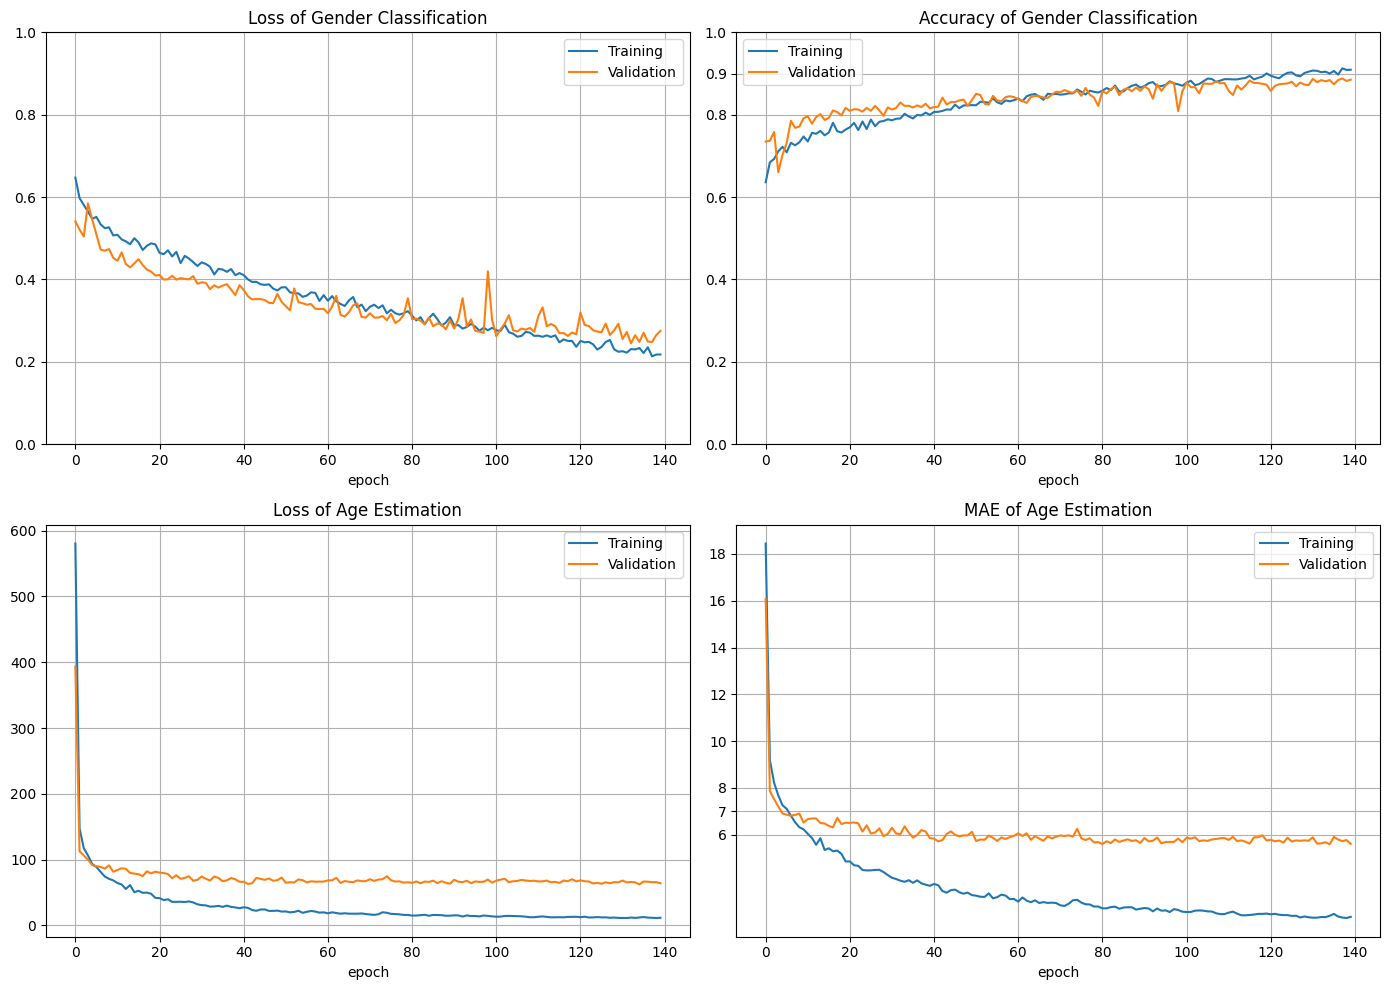

In [ ]:
#
# Add your code here
#
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,10))

# Figure 1: Loss of Gender
ax1 = fig.add_subplot(2,2,1)
ax1.plot(history.history['gender_output_loss'], label='Training')
ax1.plot(history.history['val_gender_output_loss'], label='Validation')
ax1.legend()
ax1.grid(True)
ax1.set_title('Loss of Gender Classification')
ax1.set_ylim([0,1.0])
ax1.set_xlabel('epoch')

# Figure 2: Accuracy of Gender
ax2 = fig.add_subplot(2,2,2)
ax2.plot(history.history['gender_output_accuracy'], label='Training')
ax2.plot(history.history['val_gender_output_accuracy'], label='Validation')
ax2.legend()
ax2.grid(True)
ax2.set_title('Accuracy of Gender Classification')
ax2.set_ylim([0,1.0])
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0])
ax2.set_xlabel('epoch')

# Figure 3: Loss of Age
ax3 = fig.add_subplot(2,2,3)
ax3.plot(history.history['age_output_loss'], label='Training')
ax3.plot(history.history['val_age_output_loss'], label='Validation')
ax3.legend()
ax3.grid(True)
ax3.set_title('Loss of Age Estimation')
ax3.set_xlabel('epoch')

# Figure 4: MAE of Age
ax4 = fig.add_subplot(2,2,4)
ax4.plot(history.history['age_output_mae'], label='Training')
ax4.plot(history.history['val_age_output_mae'], label='Validation')
ax4.legend()
ax4.grid(True)
ax4.set_title('MAE of Age Estimation')
ax4.set_yticks([6, 7, 8, 10, 12, 14, 16, 18])
ax4.set_xlabel('epoch')

plt.tight_layout()
plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#